# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [203]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [5]:
 # define your regions here
presel = {
    
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )", 
#             "lep_fj_dr": "( ( lep_fj_dr<0.8) )",   
            
            ### signal region
#             "LepIsolation": " ( (lep_pt<55) & (lep_isolation<0.15) ) | (lep_pt>=55)",
#             "LepMisolation": " ( (lep_pt>=55) & (lep_misolation<0.2) ) | (lep_pt<55)",
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#             "lep_fj_dr": "( ( lep_fj_dr<0.8) )",               
            ### signal region
#             "LepIsolation": " ( (lep_pt<120) & (lep_isolation<0.15) ) | (lep_pt>=120)",
        },
}

samples_dir = {
    "2017": "../eos/postprocessOct9_hidNeurons_2017",
    "2018": "../eos/postprocessOct5_hidNeurons_2018",
}

In [6]:
from finetuned_make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

years = ["2017", "2016", "2016APV", "2018"]
years = ["2017", "2018"]

events_dict = {}
events_dict["signal_region"] = {}
events_dict["qcd_region"] = {}
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict["signal_region"] = {**events_dict["signal_region"], **out}
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="qcd_region")
    events_dict["qcd_region"] = {**events_dict["qcd_region"], **out}

INFO:root:Finding DYJetsToLL_M-50_HT-600to800 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 165029 events
INFO:root:Will fill the DYJets dataframe with the remaining 165029 events
INFO:root:tot event weight 3057.8149388615484 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3841 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3841 events
INFO:root:tot event weight 6124.89967450774 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 129307 events
INFO:root:Will fill the DYJets dataframe with the remaining 129307 events
INFO:root:tot event weight 1192.4418136251331 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil s

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 27132 events
INFO:root:Will fill the SingleTop dataframe with the remaining 27132 events
INFO:root:tot event weight 90.69283597942014 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017D
INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 20199 events
INFO:root:Will fill the DYJets dataframe with the remaining 20199 events
INFO:root:tot event weight 3209.123960653712 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 893 events
INFO:root:Will fill the QCD dataframe with the remaining 893 events
INFO:root:tot event weight 0.6085285580482859 

INFO:root:Finding SingleMuon_Run2017E

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 137982 events
INFO:root:Will fill the Data dataframe with the remaining 137982 events
INFO:root:tot event weight 137982.0 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2507 events
INFO:root:Will fill the QCD dataframe with the remaining 2507 events
INFO:root:tot event weight 140.87281175011913 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 275 events
INFO:root:Will fill the WZQQ dataframe with the remaining 275 events
INFO:root:tot event weight 646.0768030041115 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Appl

INFO:root:tot event weight 19.091754732214866 

INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 11290 events
INFO:root:Will fill the SingleTop dataframe with the remaining 11290 events
INFO:root:tot event weight 2624.153750420281 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3 events
INFO:root:Will fill the WZQQ dataframe with the remaining 3 events
INFO:root:tot event weight 12.66880964237167 

INFO:root:Finding SingleElectron_Run2017E samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2017E
INFO:root:Finding SingleElectron_Run2017B samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2017B
INFO:root:Finding DYJetsToLL_M-50_HT-800to1200 samp

INFO:root:tot event weight 11571.118016544318 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1106 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1106 events
INFO:root:tot event weight 112.70734185535028 

INFO:root:Finding DYJetsToLL_M-50_HT-1200to2500 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 111156 events
INFO:root:Will fill the DYJets dataframe with the remaining 111156 events
INFO:root:tot event weight 293.52562678831174 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 997 events
INFO:root:Will fill the WZQQ dataframe with the remaining 997 events
INFO:root:tot event weight 131.84437394603194 

INFO:root:Finding QCD_Pt_1

INFO:root:Applying lep_fj_dr selection on 89396 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 89396 events
INFO:root:tot event weight 4942.339336658926 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 402714 events
INFO:root:Will fill the TTbar dataframe with the remaining 402714 events
INFO:root:tot event weight 39455.67199146389 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 609481 events
INFO:root:Will fill the DYJets dataframe with the remaining 609481 events
INFO:root:tot event weight 4153.83161094316 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 22150 events
IN

INFO:root:Will fill the TTbar dataframe with the remaining 312785 events
INFO:root:tot event weight 9618.911203798045 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 595 events
INFO:root:Will fill the QCD dataframe with the remaining 595 events
INFO:root:tot event weight 0.042066141982240075 

INFO:root:Finding DYJetsToLL_Pt-650ToInf samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 108098 events
INFO:root:Will fill the DYJets dataframe with the remaining 108098 events
INFO:root:tot event weight 92.83467235478943 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 414 events
INFO:root:Will fill the WZQQ dataframe with the remaining 414 events
INFO:root:tot ev

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1604 events
INFO:root:Will fill the QCD dataframe with the remaining 1604 events
INFO:root:tot event weight 3.8706650954782984 

INFO:root:Finding DYJetsToLL_M-50_HT-200to400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6653 events
INFO:root:Will fill the DYJets dataframe with the remaining 6653 events
INFO:root:tot event weight 11277.578054198115 

INFO:root:Finding DYJetsToLL_Pt-100To250 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 216186 events
INFO:root:Will fill the DYJets dataframe with the remaining 216186 events
INFO:root:tot event weight 10457.939081891218 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under

INFO:root:Applying lep_fj_dr selection on 8 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8 events
INFO:root:tot event weight 14.271903926482299 

INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 461539 events
INFO:root:Will fill the Data dataframe with the remaining 461539 events
INFO:root:tot event weight 461539.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3353 events
INFO:root:Will fill the SingleTop dataframe with the remaining 3353 events
INFO:root:tot event weight 10.795219135426986 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 202157 events
INFO:root:Will fill the Data dataframe with the remaining 202157 events
INFO:root:tot event weight 202157.0 

INFO:root:Findi

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6155 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6155 events
INFO:root:tot event weight 7.880818881206833 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1397 events
INFO:root:Will fill the ttH dataframe with the remaining 1397 events
INFO:root:tot event weight 4.821959373615649 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 21802 events
INFO:root:Will fill the WZQQ dataframe with the remaining 21802 events
INFO:root:tot event weight 1683.1205790120757 

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2017F
INFO:root:Finding QCD_Pt_800to1000 s

INFO:root:Will fill the WJetsLNu dataframe with the remaining 122853 events
INFO:root:tot event weight 62102.341247773926 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 13317 events
INFO:root:Will fill the SingleTop dataframe with the remaining 13317 events
INFO:root:tot event weight 3144.476440270807 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 11028 events
INFO:root:Will fill the ggF dataframe with the remaining 11028 events
INFO:root:tot event weight 128.7535937083168 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:No parquet file for WJetsToQQ_HT-200to400
INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root

INFO:root:tot event weight 333.1282460282311 

INFO:root:Finding DYJetsToLL_M-50_HT-1200to2500 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 5117 events
INFO:root:Will fill the DYJets dataframe with the remaining 5117 events
INFO:root:tot event weight 617.2541055594716 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 916 events
INFO:root:Will fill the WZQQ dataframe with the remaining 916 events
INFO:root:tot event weight 175.3906835300559 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 487 events
INFO:root:Will fill the QCD dataframe with the remaining 487 events
INFO:root:tot event weight 147180.2773896744 

INFO:root:Finding WJetsToLNu_HT-600To800 sam

INFO:root:Finding DYJetsToLL_M-50_HT-70to100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2 events
INFO:root:Will fill the DYJets dataframe with the remaining 2 events
INFO:root:tot event weight 74.74621609351613 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 272168 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 272168 events
INFO:root:tot event weight 15730.363232459931 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 797153 events
INFO:root:Will fill the TTbar dataframe with the remaining 797153 events
INFO:root:tot event weight 112822.40885757854 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine the

INFO:root:Will fill the WZQQ dataframe with the remaining 302 events
INFO:root:tot event weight 224.19974516268022 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 399 events
INFO:root:Will fill the Diboson dataframe with the remaining 399 events
INFO:root:tot event weight 81.24455514612788 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3133 events
INFO:root:Will fill the TTbar dataframe with the remaining 3133 events
INFO:root:tot event weight 552.6739006162173 

INFO:root:Finding GluGluZH_HToWW_ZTo2L_M-125 samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 7720 events
INFO:root:Will fill the Diboson dataframe with the remaining 7720 events
INFO:root:tot event weight 0.105

INFO:root:Finding DYJetsToLL_M-50_HT-200to400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 20821 events
INFO:root:Will fill the DYJets dataframe with the remaining 20821 events
INFO:root:tot event weight 14149.108203440614 

INFO:root:Finding DYJetsToLL_Pt-100To250 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 170178 events
INFO:root:Will fill the DYJets dataframe with the remaining 170178 events
INFO:root:tot event weight 11773.026495605834 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 61205 events
INFO:root:Will fill the Data dataframe with the remaining 61205 events
INFO:root:tot event weight 61205.0 

INFO:root:Finding DYJetsToLL_M-50_HT-600to800 samples and should combine them under DYJets
INFO:root:---> Using already stored 

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 13722 events
INFO:root:Will fill the SingleTop dataframe with the remaining 13722 events
INFO:root:tot event weight 44.380030207703555 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1839 events
INFO:root:Will fill the DYJets dataframe with the remaining 1839 events
INFO:root:tot event weight 287.926605066056 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 773 events
INFO:root:Will fill the QCD dataframe with the remaining 773 events
INFO:root:tot event weight 0.7273940727274462 

INFO:root:Finding SingleMuon_Run2018A samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018A
INFO:root:Finding WW samples and should

INFO:root:Finding EGamma_Run2018D samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 159644 events
INFO:root:Will fill the Data dataframe with the remaining 159644 events
INFO:root:tot event weight 159644.0 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1947 events
INFO:root:Will fill the QCD dataframe with the remaining 1947 events
INFO:root:tot event weight 151.00385618577045 

INFO:root:Finding EGamma_Run2018B samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 45126 events
INFO:root:Will fill the Data dataframe with the remaining 45126 events
INFO:root:tot event weight 45126.0 

INFO:root:Finding SingleMuon_Run2018C samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018C
INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:r

INFO:root:Applying lep_fj_dr selection on 1484 events
INFO:root:Will fill the ggF dataframe with the remaining 1484 events
INFO:root:tot event weight 17.625413084074285 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 11 events
INFO:root:Will fill the WZQQ dataframe with the remaining 11 events
INFO:root:tot event weight 176.8390449496968 

INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1962 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1962 events
INFO:root:tot event weight 482.59692427738673 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 27 events
INFO:root:Will fill t

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 12951 events
INFO:root:Will fill the WZQQ dataframe with the remaining 12951 events
INFO:root:tot event weight 2435.953817580037 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4225 events
INFO:root:Will fill the QCD dataframe with the remaining 4225 events
INFO:root:tot event weight 1286061.0498227621 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 13788 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 13788 events
INFO:root:tot event weight 1744.372333456529 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selecti

In [7]:
events_dict.keys()

dict_keys(['signal_region', 'qcd_region'])

In [8]:
events_dict["signal_region"].keys()

dict_keys(['2017', '2018'])

In [9]:
events_dict[years[0]]["ele"].keys()

KeyError: '2017'

In [ ]:
events_dict[years[0]]["mu"]["TTbar"]

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

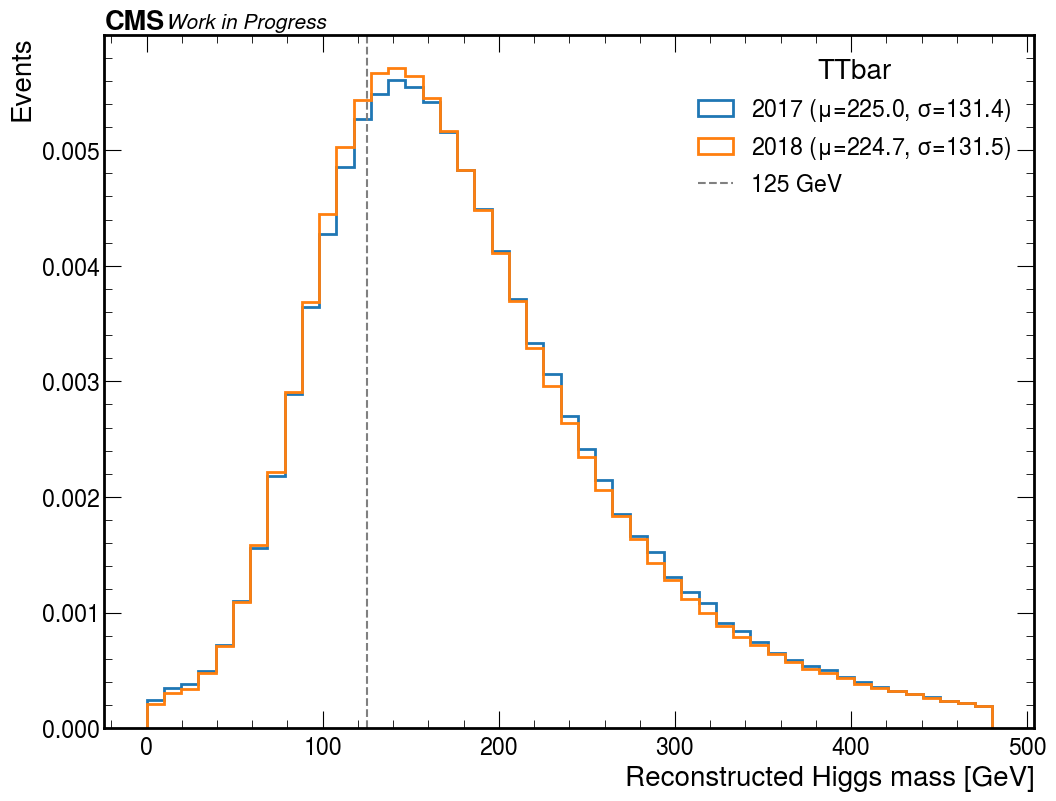

In [144]:
plt.rcParams.update({"font.size": 20})

bins = 50

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "TTbar"
channels = ["ele", "mu"]
region = "signal_region"

fig, ax = plt.subplots(figsize=(12, 9))

for year in ["2017", "2018"]:
        
    df1 = events_dict[region][year]["mu"][sample]    
    df2 = events_dict[region][year]["ele"][sample]
                
    df1["weight"] = df1["weight_mu"]
    df2["weight"] = df2["weight_ele"]        

    df = pd.concat([df1, df2])
    
    x = df["rec_higgs_m"]
    w = df["weight"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=w,
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{year} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

# hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")        

In [179]:
np.linspace(0.9, 0.99, 19)

array([0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 ])

In [419]:
# tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8]
# tagger_cuts = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
# tagger_cuts = np.linspace(0.7, 0.97, 28)

# tagger_cuts = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]
# tagger_cuts = [0.90, 0.925, 0.95, 0.975, 0.99]
# tagger_cuts = np.linspace(0.9, 0.99, 19)
# tagger_cuts = np.linspace(0.9, 0.99, 19*2-1)

# tagger_cuts = np.linspace(0.2, 0.97, 30)

tagger_cuts = np.linspace(0.1, 0.85, 25)

wp = 0.85
mass_window = [50, 200]

years = ["2017", "2018"]
channels = ["ele", "mu"]

s_over_b = {}

for tagger in [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_HPO",

    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:

        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    df = events_dict[year][ch][sample]

                    # add tagger cut
                    df = df[df[tagger]>tagger_cut]
                    # add mass window
                    df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                    # remove high weight events
                    df = df[df["event_weight"]<145]

                    # add inverted tagger cut
                    df = df[df[tagger]<wp]

                    ##############################    
                    if "WJets" in sample:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.1
tagger cut 0.13125
tagger cut 0.1625
tagger cut 0.19375
tagger cut 0.225
tagger cut 0.25625
tagger cut 0.2875
tagger cut 0.31875
tagger cut 0.35
tagger cut 0.38125
tagger cut 0.4125
tagger cut 0.44375
tagger cut 0.475
tagger cut 0.50625
tagger cut 0.5375
tagger cut 0.56875
tagger cut 0.6
tagger cut 0.63125
tagger cut 0.6625
tagger cut 0.69375
tagger cut 0.725
tagger cut 0.75625
tagger cut 0.7875
tagger cut 0.81875
tagger cut 0.85


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_23010/4122713377.py:65: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b[tagger].append(s/math.sqrt(b))


TAGGER: fj_ParT_score_finetuned_v2_nor2
tagger cut 0.1
tagger cut 0.13125
tagger cut 0.1625
tagger cut 0.19375
tagger cut 0.225
tagger cut 0.25625
tagger cut 0.2875
tagger cut 0.31875
tagger cut 0.35
tagger cut 0.38125
tagger cut 0.4125
tagger cut 0.44375
tagger cut 0.475
tagger cut 0.50625
tagger cut 0.5375
tagger cut 0.56875
tagger cut 0.6
tagger cut 0.63125
tagger cut 0.6625
tagger cut 0.69375
tagger cut 0.725
tagger cut 0.75625
tagger cut 0.7875
tagger cut 0.81875
tagger cut 0.85


In [327]:
np.linspace(0.7, 0.97, 28)

array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97])

In [343]:
np.linspace(0.2, 0.85, 20)

array([0.2       , 0.23421053, 0.26842105, 0.30263158, 0.33684211,
       0.37105263, 0.40526316, 0.43947368, 0.47368421, 0.50789474,
       0.54210526, 0.57631579, 0.61052632, 0.64473684, 0.67894737,
       0.71315789, 0.74736842, 0.78157895, 0.81578947, 0.85      ])

In [482]:
# tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8]
# tagger_cuts = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


# tagger_cuts = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]
# tagger_cuts = [0.90, 0.925, 0.95, 0.975, 0.99]

tagger_cuts = np.linspace(0.9, 0.99, 19)
# tagger_cuts = np.linspace(0.7, 0.97, 28)
# tagger_cuts = np.linspace(0.1, 0.85, 25)

wp = 0.85
mass_window = [50, 200]

years = ["2017", "2018"]

channels = ["ele", "mu"]

s_over_b = {}

for tagger in [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_HPO",

    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:

        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample=="Data":
                        continue
                        
                    df = events_dict[year][ch][sample]

                    # add tagger cut
                    df = df[df[tagger]>tagger_cut]
                    # add mass window
                    df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                    # remove high weight events
                    df = df[df["event_weight"]<145]

                    # add inverted tagger cut
#                     df = df[df[tagger]<wp]

                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.9
tagger cut 0.905
tagger cut 0.91
tagger cut 0.915
tagger cut 0.92
tagger cut 0.925
tagger cut 0.93
tagger cut 0.935
tagger cut 0.9400000000000001
tagger cut 0.9450000000000001
tagger cut 0.95
tagger cut 0.955
tagger cut 0.96
tagger cut 0.965
tagger cut 0.97
tagger cut 0.975
tagger cut 0.98
tagger cut 0.985
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned_v2_nor2
tagger cut 0.9
tagger cut 0.905
tagger cut 0.91
tagger cut 0.915
tagger cut 0.92
tagger cut 0.925
tagger cut 0.93
tagger cut 0.935
tagger cut 0.9400000000000001
tagger cut 0.9450000000000001
tagger cut 0.95
tagger cut 0.955
tagger cut 0.96
tagger cut 0.965
tagger cut 0.97
tagger cut 0.975
tagger cut 0.98
tagger cut 0.985
tagger cut 0.99


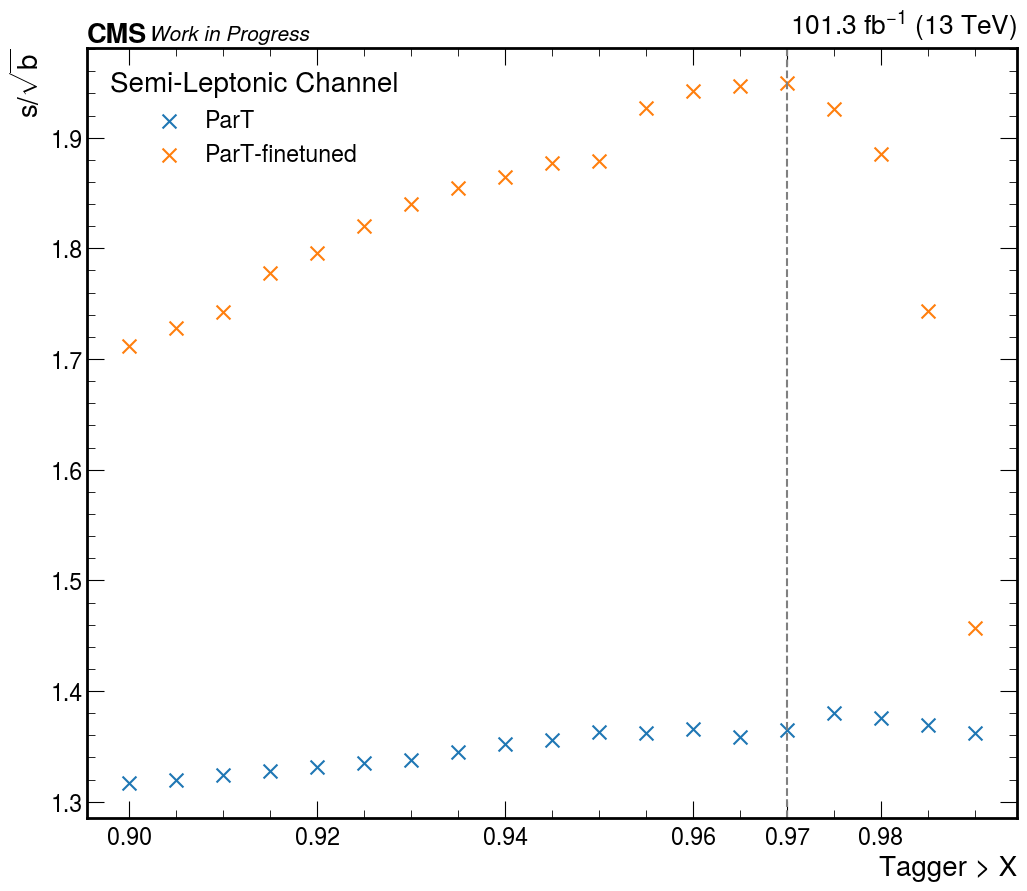

In [483]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",
    f"fj_ParT_score_finetuned_v2_nor2",
]:
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.97, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"$s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])


lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_high_signal_region.pdf")

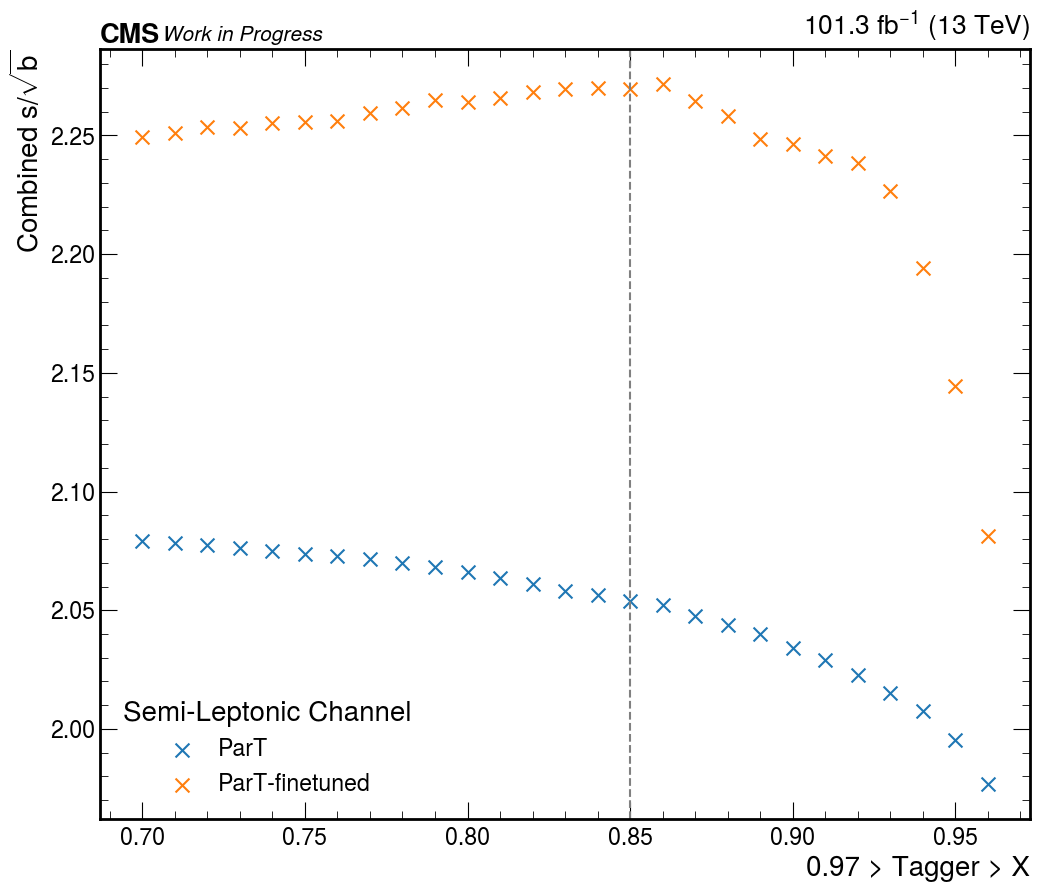

In [477]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))
years = ["2018", "2017"]


soverb_high = 1.95

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",
    f"fj_ParT_score_finetuned_v2_nor2",
]:
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.85, color="grey", linestyle="--")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"Combined $s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_medium_signal_region.pdf")

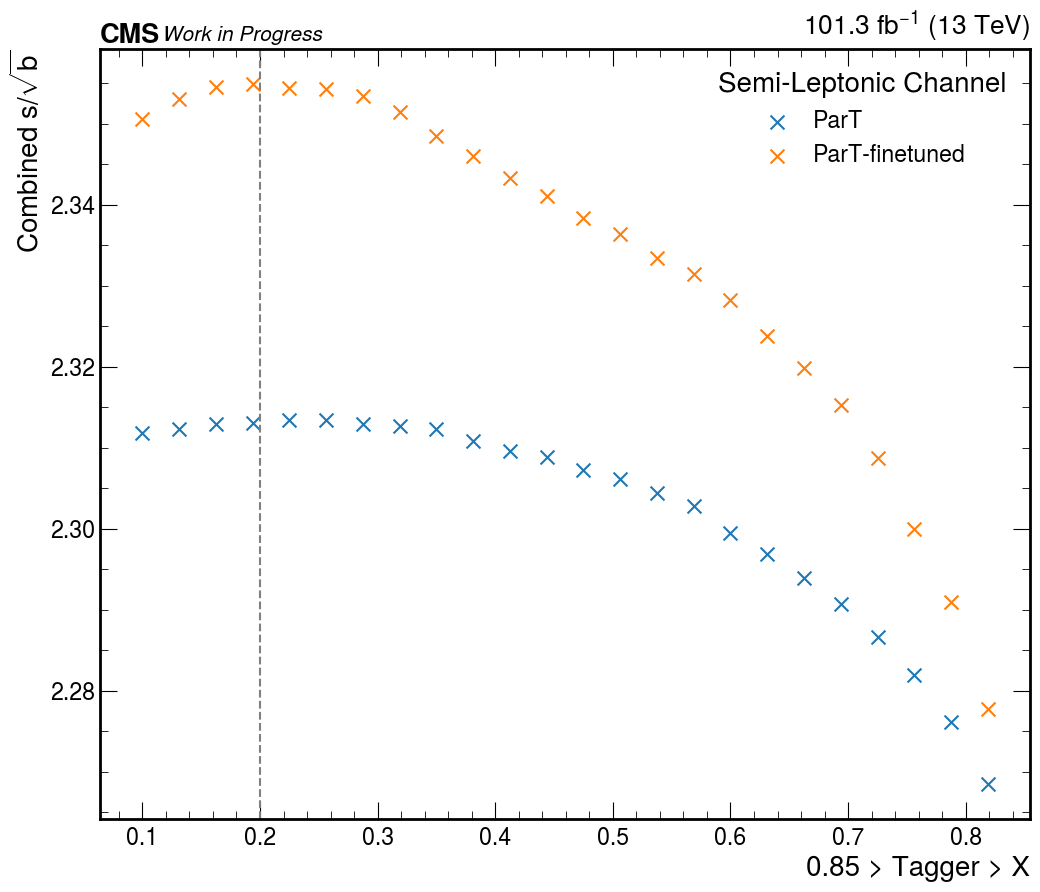

In [480]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))
years = ["2018", "2017"]


soverb_high = 2.26

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",


#         f"fj_ParT_score_finetuned_v2_10_5",
#         f"fj_ParT_score_finetuned_v2_10_12",   ### best: --start-lr 6.75e-3 --num-epochs 2500 norelu

#         f"fj_ParT_score_finetuned_v2_r1",
#         f"fj_ParT_score_finetuned_v2_r2",
#         f"fj_ParT_score_finetuned_v2_rs1",
#         f"fj_ParT_score_finetuned_v2_rs2",

#         f"fj_ParT_score_finetuned_v2_nor1",
    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.2, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"Combined $s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])


lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_low_signal_region.pdf")

## 1d-hists

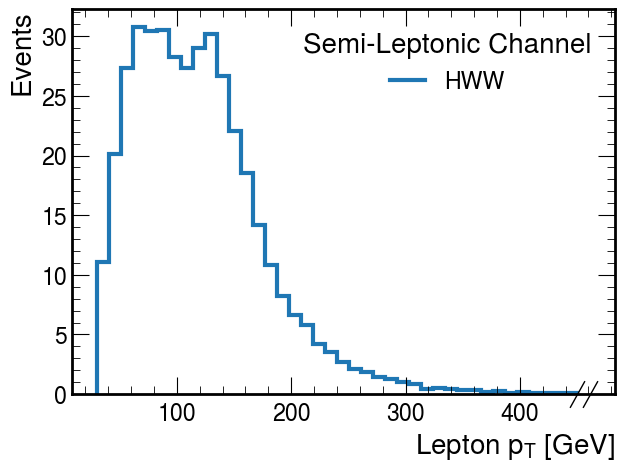

In [11]:
plt.rcParams.update({"font.size": 20})

sample = "HWW"

# make histogram
h = hist2.Hist(
    hist2.axis.Regular(40, 30, 450, name="var", label=r"Lepton $p_T$ [GeV]", overflow=True),
)    

for year in years:
    for ch in channels:

        df = events_dict[year][ch][sample]

        h.fill(
            var=df["lep_pt"],
            weight=df["event_weight"]
        )

# plot histogram
fig, ax = plt.subplots(figsize=(7, 5))

hep.histplot(
    h,
    ax=ax,
    label=sample,
    linewidth=3,
#     density=True
)

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

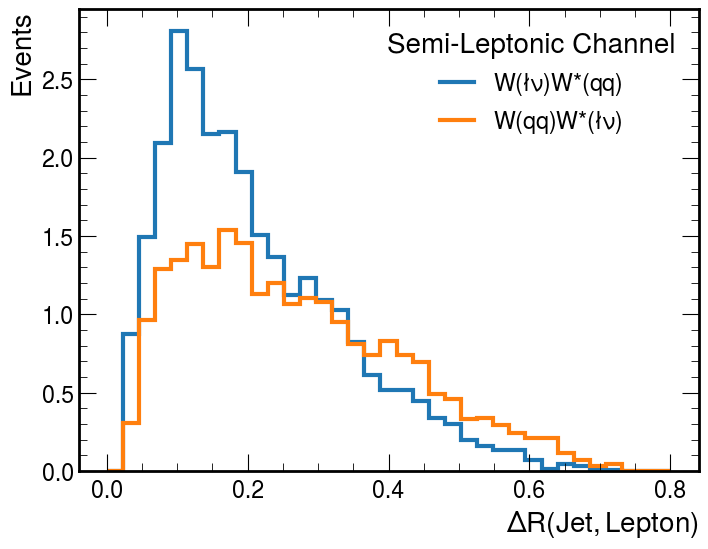

In [11]:
# make histogram
h = hist2.Hist(
    hist2.axis.Regular(35, 0.0, 0.8, name="var", label=r"$\Delta R(Jet, Lepton)$", overflow=True),
    hist2.axis.Boolean(name="from_W")        
)

for year in years:
    for ch in channels:
        
        h.fill(
            var=events_dict[year][ch]["HWW"]["lep_fj_dr"],
            from_W=events_dict[year][ch]["HWW"]["fj_H_VV_isVlepton"]==True,
            weight=events_dict[year][ch]["HWW"]["event_weight"]
        )

# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

hep.histplot(
    h[{"from_W": 1}],
    ax=ax,
    label=r"W($\l\nu$)W*(qq)",
    linewidth=3,
#     density=True
)
hep.histplot(
    h[{"from_W": 0}],
    ax=ax,
    label=r"W(qq)W*($\l\nu$)",
    linewidth=3,
#     density=True    
)
     
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

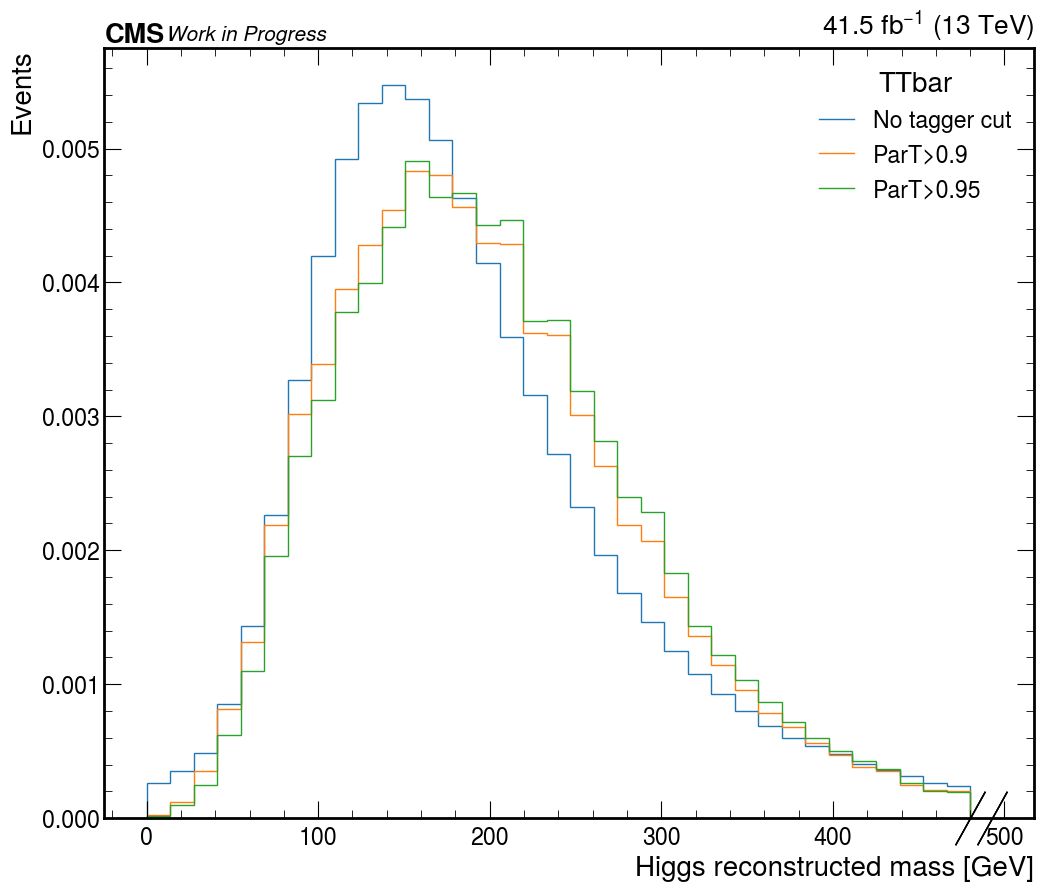

In [31]:
list(h.axes[0])

['No tagger cut', 'ParT>0.9', 'ParT>0.95']

# Stacked hists

In [475]:
vars_to_plot = [
#     "fj_minus_lep_m",
#     "fj_pt",
#     "lep_pt",
#     "fj_msoftdrop",
#     "fj_bjets_ophem",
#     "fj_bjets",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "ht",
#     "met_fj_dphi",
#     "deta",
#     "met",
#     "mjj",
#     "fj_pt_over_lep_pt",
    "rec_higgs_m",
#     "rec_higgs_pt",
#     "rec_higgs_pt_over_lep_pt",    
#     "golden_var",
#     "rec_dphi_WW",
#     "fj_ParT_mass",
#     "fj_ParticleNet_mass"
#     "nj",
#     "inclusive_score",
#     "fj_ParT_score_finetuned_v2_10_12",
]

samples_to_plot = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
#     "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

In [484]:
tagger = "fj_ParT_score_finetuned_v2_nor2"
tagger = "fj_ParT_score"

presel = {
    "High purity signal region": f"({tagger}>0.99)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   

#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)"#" & (lep_fj_dr>0.3)",

}

channels = ["ele", "mu"]
years = ["2018", "2017"]
# years = ["2018"]

region = "signal_region"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                for k, v in presel.items():

                    if "QCD" in k:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]
                        df = df[df["event_weight"]<140]

                    df = df.query(v)
                
                hists[var].fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"],
                )     

Will plot rec_higgs_m histogram


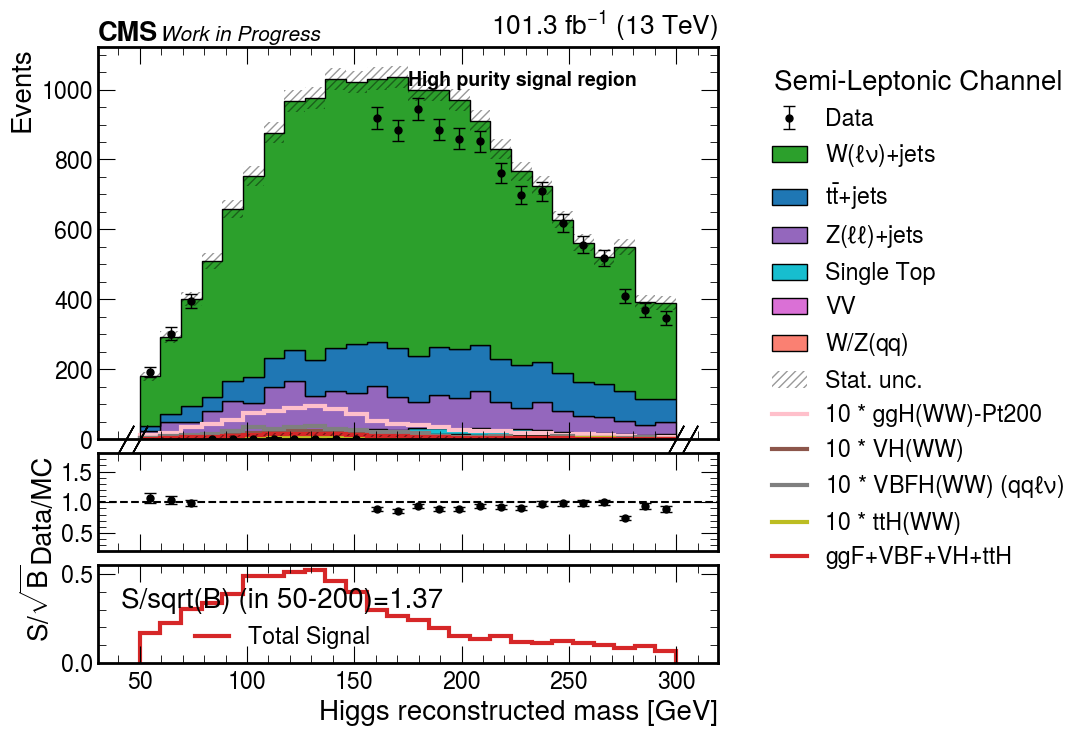

In [485]:
plt.rcParams.update({"font.size": 20})
from utils import plot_hists
plot_hists(years, channels, hists, vars_to_plot,             
            add_data=True,
            logy=False,
            add_soverb=True,
            only_sig=False,
            mult=10,
            outpath="/Users/fmokhtar/Desktop/farakikopku/",
            text_=list(presel.keys())[0],
            blind_region=[80,150],
          )

# soverb

In [27]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [64]:
tagger = "fj_ParT_score_finetuned_v2_nor2"
# tagger = "ParT_finetuned"

# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"


presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    
#     "WJets control region + dR>0.3": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.3)",
#     "WJets control region + dR>0.4": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.4)",
#     "WJets control region + dR>0.5": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.5)",


#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      
#     "Top control region + dR>0.2": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.2)",  
#     "Top control region + dR>0.3": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.3)",  
#     "Top control region + dR>0.4": f"({tagger}<0.30) & (n_bjets_T>0) & (lep_fj_dr>0.4)",  

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]
region = "signal_region"

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0


for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            df = events_dict[region][year][ch][sample]

            df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

            df = df[df["event_weight"]<140]

            for k, v in presel.items():
                df = df.query(v)      

            if sample in utils.signals:
                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum() 

In [66]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

print("\033[1m" + f"{list(presel.keys())[0]} ({','.join(years)}):" + '\033[0m')

# print("------------------------")

# print("\033[1m" + rf"s/sqrt(b): {deno_sig/math.sqrt(deno_bkg):.2f}" + '\033[0m')
# print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
#     print(f"- {sample}: {(num_sig[sample]/deno_sig):.3f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="WJetsLNu":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

WJets control region (2018,2017):
Signal: 231.54
- ttH: 1%
- VH: 14%
- VBF: 25%
- ggF: 61%
------------------------
Background: 207231.61
- Others: 1%
- TTbar: 3%
- QCD: 11%
- DYJets: 16%
- WJetsLNu: 70%


# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

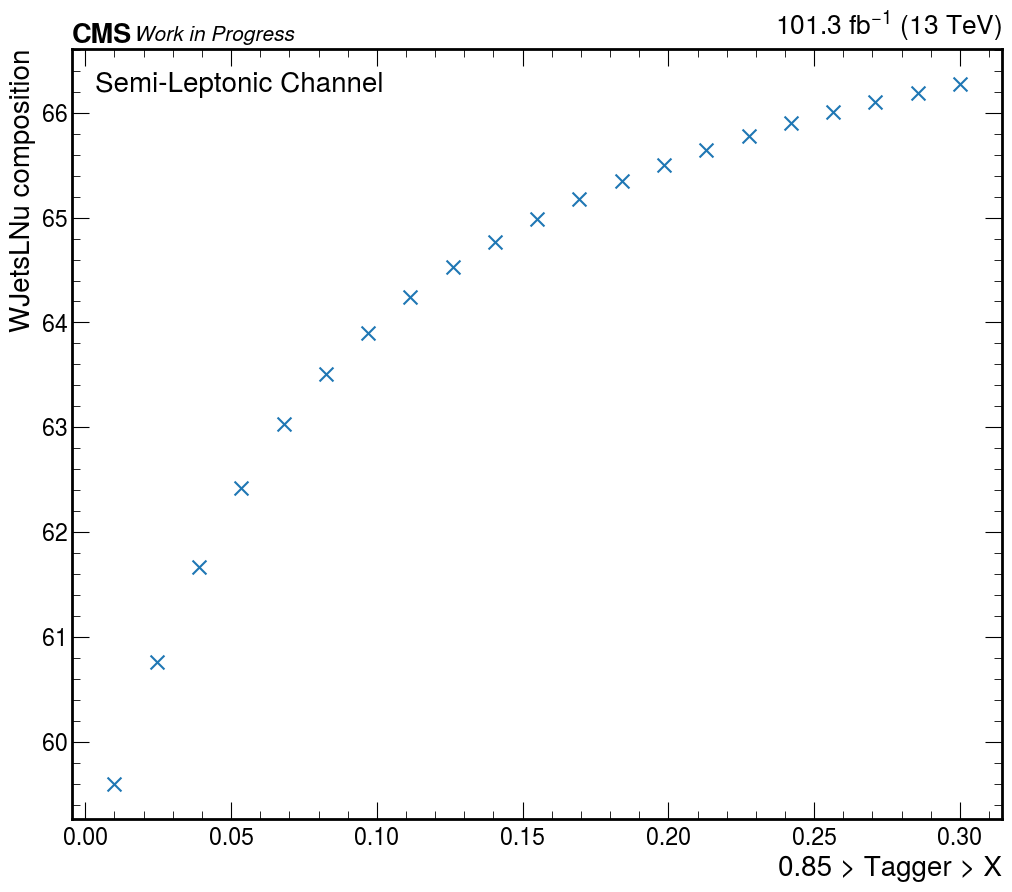

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

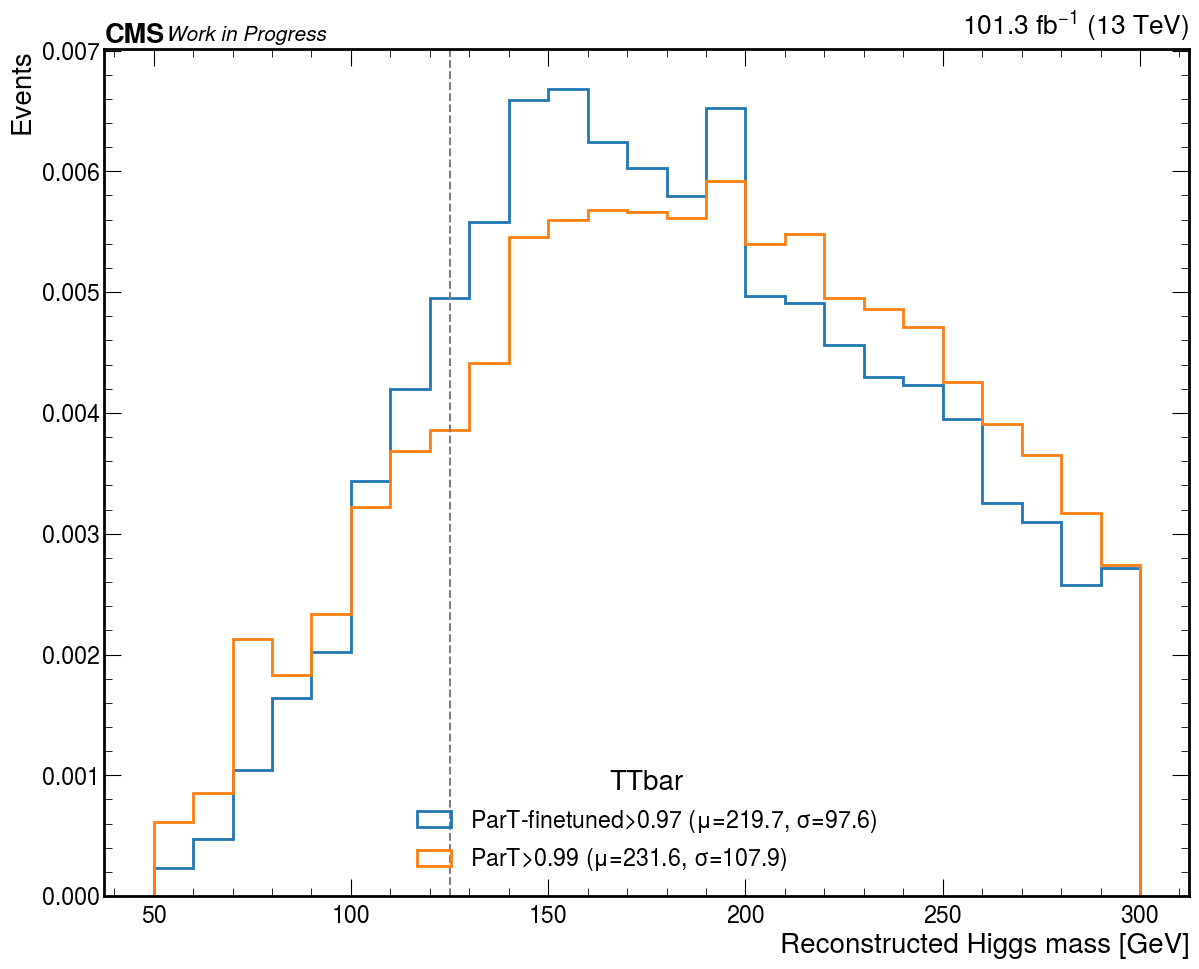

In [490]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
    "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
    "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "TTbar"
channels = ["mu", "ele"]
years = ["2018", "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df1["weight"] = df1["weight_mu"]
        df2["weight"] = df2["weight_ele"]   

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df1["weight"] = df1["weight_mu"]
            df2["weight"] = df2["weight_ele"]   

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
    w = df1["weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
        weights=w,
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [493]:
os.mkdir("ttt")

In [513]:
! ls ttt

a.txt   log.txt t


In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

In [515]:
for f in log_files:
    print(f)
    all_files.remove(f)

ttt/log.txt


In [516]:
all_files

['ttt/t', 'ttt/a.txt']

In [517]:
for f in all_files:
    print(f)
    os.remove(f)

ttt/t


PermissionError: [Errno 1] Operation not permitted: 'ttt/t'

In [518]:
os.remove("ttt/t")

PermissionError: [Errno 1] Operation not permitted: 'ttt/t'

In [525]:
for root, dirs, files in os.walk("ttt/"):
    print(files)

['log.txt', 'a.txt']


In [524]:
import shutil
outpath = "ttt"
filelist = [f for f in os.listdir(outpath) if not f.endswith(".txt")]  # don't remove the newly created logs.txt
for f in filelist:
    try:
        shutil.rmtree(os.path.join(outpath, f))
    except Exception:
        os.remove(os.path.join(outpath, f))

# QCD

In [460]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1}],
        ax=ax,
        histtype="step",
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1}].values()
    tot_val = h[{"region": region2}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()


    hep.histplot(
        data_val / tot_val,
        h[{"region": region1}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=sample)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/ratio_{sample}.pdf")   

In [470]:
tagger = "fj_ParT_score_finetuned_v2_nor2"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

channels = ["ele", "mu"]
years = ["2018", "2017"]
# years = ["2018"]

sample = "Data"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.Regular(26, 50, 300, name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
        )        
        
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for k, v in presel.items():
                
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]
                    df = df[df["event_weight"]<140]

                df = df.query(v)

                hists[var].fill(
                    region=k,
                    var=df[var],
                    weight=df["event_weight"],
                )     

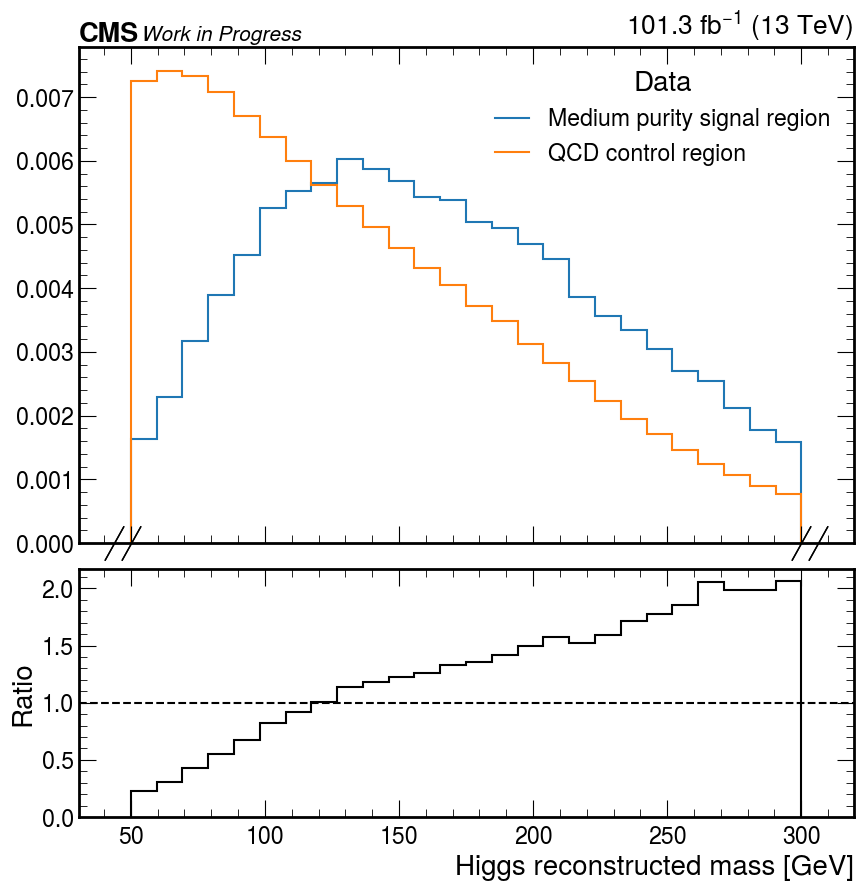

In [474]:
plot_ratio(hists["rec_higgs_m"], years, 
           region1 = "Medium purity signal region", 
#            region1 = "0.85>Tagger>0.20",
           region2 = "QCD control region", 
           sample=sample,
           tag="medium"
          )

In [307]:
data_val

array([ 80.99279675, 409.54236512,  82.26598038,  68.2721766 ,
        61.96179467, 629.3935108 ,  84.44308838, 334.59559559,
        27.88934048, 354.17824292, 677.35180032, 656.35211515,
        22.9002048 , 316.77537489,  11.40274667, 369.52659166,
       382.63748775, 316.94483475,   5.19111578,  24.54538884,
         5.00189243, 310.30746438,  67.53162891,  40.18429337,
         0.92081578,  20.98657427])

In [248]:
data_val/data_val.sum()

array([0.01510469, 0.0763773 , 0.01534213, 0.01273237, 0.01155552,
       0.11737828, 0.01574815, 0.06240016, 0.0052012 , 0.06605221,
       0.12632223, 0.1224059 , 0.00427076, 0.05907679, 0.00212655,
       0.06891459, 0.0713597 , 0.05910839, 0.00096811, 0.00457757,
       0.00093282, 0.05787056, 0.01259426, 0.00749414, 0.00017173,
       0.00391388])

In [249]:
yerr

array([[0.00085253, 0.00258319, 0.00099143, 0.00086423, 0.00060892,
        0.00243458, 0.00108837, 0.00213468, 0.00063159, 0.00290844,
        0.00295638, 0.00556874, 0.00070096, 0.00415065, 0.00070744,
        0.00403818, 0.00433611, 0.00469124, 0.00050401, 0.0014849 ,
        0.0008205 , 0.01522002, 0.00346789, 0.00346808, 0.00077798,
        0.00278738],
       [0.00095274, 0.00271405, 0.00110701, 0.00097545, 0.00069143,
        0.00253358, 0.00121351, 0.00225463, 0.00076333, 0.00306717,
        0.00307219, 0.0057904 , 0.00086398, 0.00439054, 0.00095163,
        0.00425382, 0.00456355, 0.0049623 , 0.00078277, 0.00181722,
        0.00128495, 0.01610907, 0.00391674, 0.00406092, 0.00226279,
        0.00346786]])

In [221]:
tot_val/tot_val.sum()

array([0.06907256, 0.05134574, 0.05986211, 0.06253333, 0.08453052,
       0.06754779, 0.05525016, 0.05615649, 0.05449384, 0.04240672,
       0.05770694, 0.03015714, 0.04443361, 0.02810085, 0.03083251,
       0.03119818, 0.02956601, 0.02486932, 0.02866551, 0.02172643,
       0.01726186, 0.00758466, 0.01549878, 0.01193462, 0.00657473,
       0.01068963])

In [147]:
len(h[{"region": region1}].axes.edges)

1

In [85]:
qcdx

0       148.219176
3       244.822679
4       708.026422
5       557.646437
6       805.188935
           ...    
2975    409.656266
2983    792.537073
2984    474.883550
2986     53.395040
2987    253.914229
Name: rec_higgs_m, Length: 288212, dtype: float64

In [87]:
sigx

561      571.445924
573      483.698187
1388     296.182482
3049     480.039905
4104     513.197200
           ...     
2317    1157.786586
2470     523.977852
2628     185.847641
2760    1349.163471
2873     459.066443
Name: rec_higgs_m, Length: 1649, dtype: float64

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_44458/2370009794.py:8: RuntimeWarning: invalid value encountered in divide
  ns[0] / ns[1], # maybe check for div-by-zero!


<BarContainer object of 20 artists>

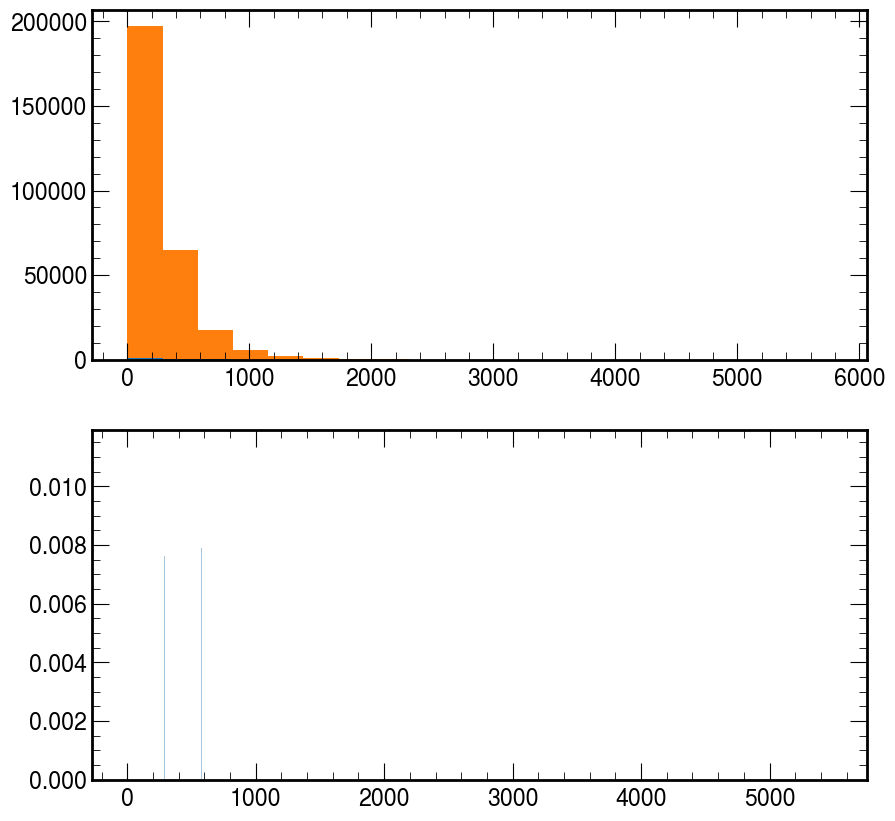

In [91]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ns, bins, patches = ax1.hist([sigx, qcdx],
                      histtype='stepfilled',
                      bins=20,
                      )

ax2.bar(bins[:-1],     # this is what makes it comparable
        ns[0] / ns[1], # maybe check for div-by-zero!
        alpha=0.4)

In [90]:
ns[0] / ns[1]

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_44458/1248563440.py:1: RuntimeWarning: divide by zero encountered in divide
  ns[0] / ns[1]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_44458/1248563440.py:1: RuntimeWarning: invalid value encountered in divide
  ns[0] / ns[1]


array([203.59504132, 131.21703854, 126.85294118, 147.24324324,
       174.        , 863.        , 394.        ,          inf,
        88.        ,          inf,          inf,          inf,
                inf,          inf,          inf,          inf,
                nan,          inf,          nan,          inf])

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

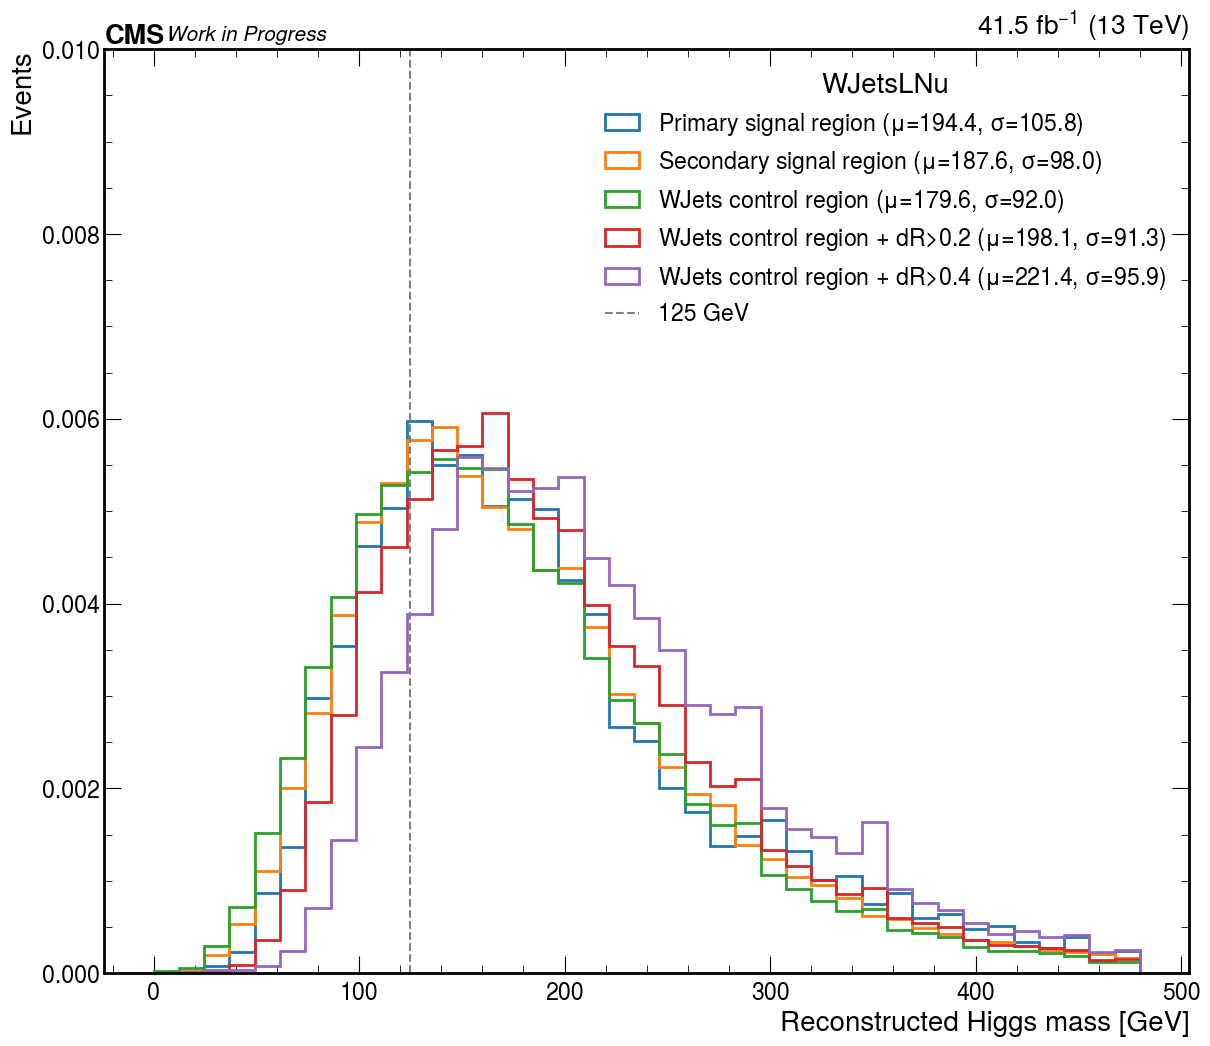

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  

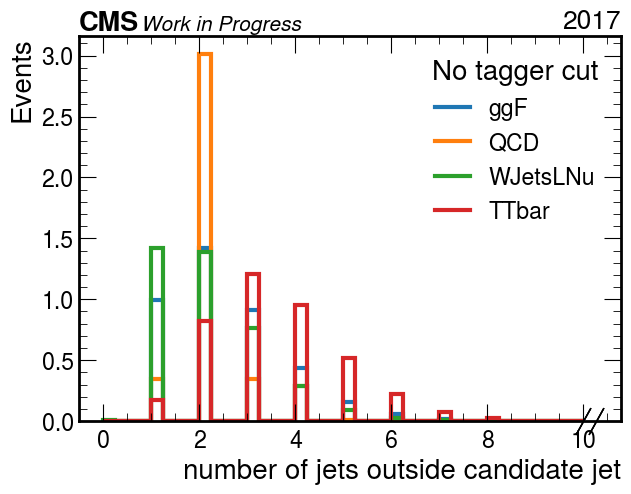

In [20]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "nj"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(7, 5))

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]

            # tagger cut
    #         df = df[df["inclusive_score"]>0.9]

    #         df = df[df["lep_fj_dr"]>0.03]        
            df = df[df["n_bjets_M"]<2]
    #         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

            h.fill(
                samples=sample,
                var=df[var],
                weight=df["event_weight"]
            )

for sample in samples_to_plot:
    if sample in utils.sig_labels:
        lab = utils.sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"No tagger cut")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

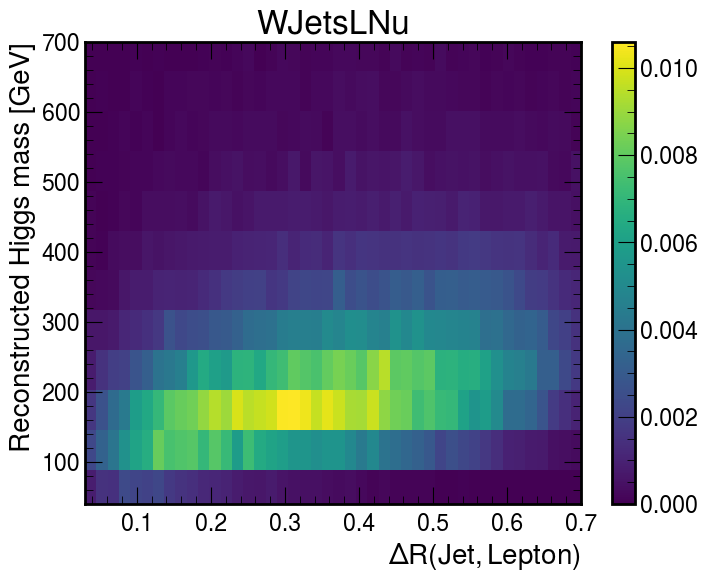

In [16]:
samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

var1 = "lep_fj_dr"
var2 = "rec_higgs_m"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))

for sample in samples_to_plot:
    for year in years:
        for i, ch in enumerate(channels):
            df = events_dict[year][ch][sample]

            df = df[df["inclusive_score"]>0.99]
            df = df[df["fj_pt"]>220]

            if i==0:
                dff = df
            else:
                dff = pd.concat([dff, df])


    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[50,50]
          )

ax.set_xlim(0.03,0.7)
ax.set_ylim(40, 700)
ax.set_xlabel(r"$\Delta R(Jet,Lepton)}$");
ax.set_ylabel(r"Reconstructed Higgs mass [GeV]");
ax.set_title(sample)
plt.colorbar()

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')